This notebook experiments with FID (Fretcher inception distance) metrics

In [150]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data

import torchvision.models as models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

# from lib.network import InceptionV3
# from lib.metrics import calculate_activation_statistics, calculate_frechet_distance, calculate_fretchet

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import linalg


In [151]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# which cuda to use
cuda_num = 0


In [152]:

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


In [153]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048):
    model.eval()
    act=np.empty((len(images), dims))

    pred = model(images)[0]
    # print(pred)

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


In [154]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2


    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))


    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


In [155]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model)
     mu_2,std_2=calculate_activation_statistics(images_fake,model)

     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value


In [156]:
def calculate_kl_score(syn_batch, ref_batch, real_batch):

    def tensor_to_numpy(img):
        img = img.numpy()
        img += max(-img.min(), 0)
        if img.max() != 0:
            img /= img.max()
        img *= 255
        img = img.astype(np.uint8)
        img = np.transpose(img, [1, 2, 0])
        return img

    num_images = min(syn_batch.size()[0], ref_batch.size()[0], real_batch.size()[0])
    num_channels = syn_batch.size(1)
    num_bins = (num_channels * 256)

    synth_histograms = np.zeros((num_bins,), dtype=float)
    ref_histograms = np.zeros((num_bins,), dtype=float)
    real_histograms = np.zeros((num_bins,), dtype=float)

    for index in range(num_images):
        synth_image = tensor_to_numpy(syn_batch[index, :, :, :])
        ref_image = tensor_to_numpy(ref_batch[index, :, :, :])
        real_image = tensor_to_numpy(real_batch[index, :, :, :])

        # offset channels for one continous histogram
        for chan in range(1, num_channels):
            synth_image[:, :, chan] += chan * 256
            ref_image[:, :, chan] += chan * 256
            real_image[:, :, chan] += chan * 256

        synth_hist, _ = np.histogram(synth_image.ravel(), bins=num_bins, range=(0, 256))
        ref_hist, _ = np.histogram(ref_image.ravel(), bins=num_bins, range=(0, 256))
        real_hist, _ = np.histogram(real_image.ravel(), bins=num_bins, range=(0, 256))

        synth_histograms += synth_hist
        ref_histograms += ref_hist
        real_histograms += real_hist

    avg_synth_hist = synth_histograms / num_images
    avg_ref_hist = ref_histograms / num_images
    avg_real_hist = real_histograms / num_images

    relative_entropy = avg_synth_hist * np.log(avg_synth_hist / avg_ref_hist, where=avg_synth_hist != 0)
    kl_synth_ref = np.sum(relative_entropy, where=np.isfinite(relative_entropy))

    relative_entropy = avg_synth_hist * np.log(avg_synth_hist / avg_real_hist, where=avg_synth_hist != 0)
    kl_synth_real =  np.sum(relative_entropy, where=np.isfinite(relative_entropy))

    relative_entropy = avg_ref_hist * np.log(avg_ref_hist / avg_real_hist, where=avg_ref_hist != 0)
    kl_ref_real =  np.sum(relative_entropy, where=np.isfinite(relative_entropy))

    return {
        'kl divergence': {
            'synth-ref': kl_synth_ref,
            'synth-real': kl_synth_real,
            'ref-real': kl_ref_real,
            },
        }


Define transform for compatibility with pytroch

In [157]:
transform = v2.Compose([
            v2.Resize((256, 256)),
            v2.ToImageTensor(),
            ])


transform_norm = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToImageTensor(),
    v2.ConvertImageDtype(),
    v2.Normalize((0, 0, 0), (1, 1, 1))
    ])

transfor_to_img = v2.ToPILImage()


Define Inception Model and copy it to GPU

In [158]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])
inception_model.cuda(cuda_num)


c:\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


InceptionV3(
  (blocks): ModuleList(
    (0): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      

## Test 1

This test in performed on different images but with same colors (dogs on grass), for simplicity I've chosen two different dogs breads (Afghan hound and Japan spainel)

In [159]:
test1_path = "images/test1/"

batch_size = 1

dataset_test1 = ImageFolder(root=f'{test1_path}', transform=transform_norm)

class_labels = dataset_test1.find_classes(test1_path)[1]

set1 = Data.Subset(dataset_test1, [idx for idx, (image, label) in 
                                   enumerate(dataset_test1) if label == class_labels['set_1']])
set2 = Data.Subset(dataset_test1, [idx for idx, (image, label) in 
                                   enumerate(dataset_test1) if label == class_labels['set_2']])
set3 = Data.Subset(dataset_test1, [idx for idx, (image, label) in 
                                   enumerate(dataset_test1) if label == class_labels['set_3']])

set1_dataloader = Data.DataLoader(set1, batch_size=1, pin_memory=True, num_workers=4)
set2_dataloader = Data.DataLoader(set2, batch_size=1, pin_memory=True, num_workers=4)


In [160]:
def show(inp, label):
    fig = plt.gcf()
    plt.imshow(inp.permute(1,2,0))
    plt.title(label)


## Test 1

FID used on same pictures with horizontal flip and vertical flip

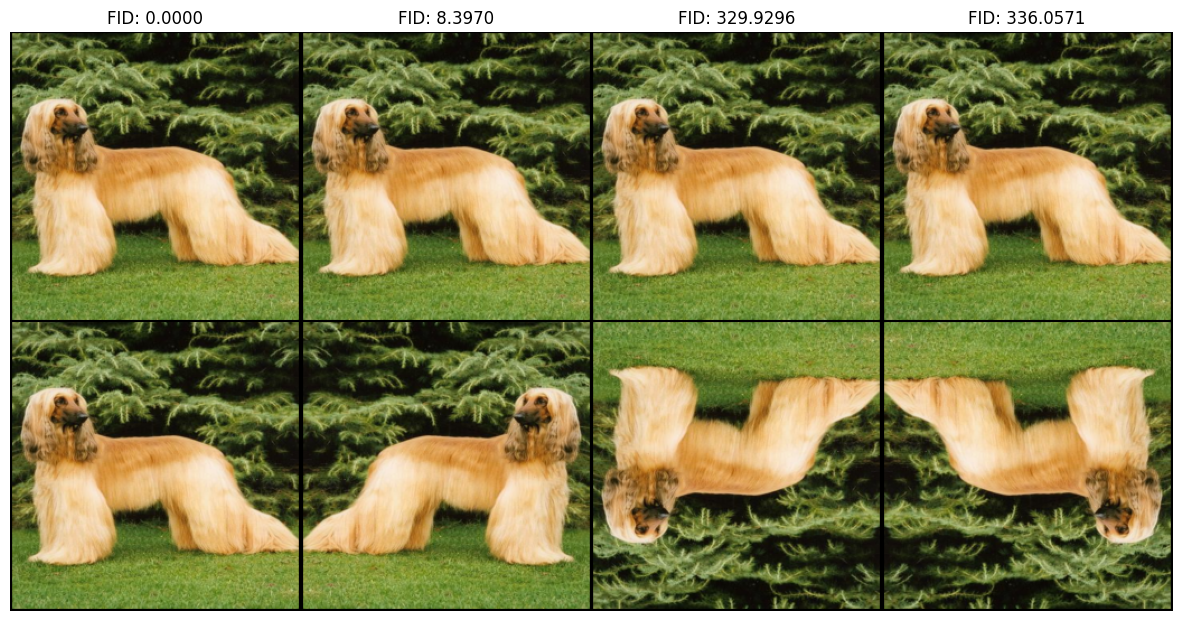

In [161]:
horizontal_flip_transform = v2.RandomHorizontalFlip(1.0)
vertical_flip_transform = v2.RandomVerticalFlip(1.0)

test_img = next(iter(set1_dataloader))[0].cuda(dev)

hflip_test_img = horizontal_flip_transform(test_img)
vflip_test_img = vertical_flip_transform(test_img)
hvflip_test_img = horizontal_flip_transform(vflip_test_img)

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

for ax in axes.ravel():
    ax.axis("off")
    ax.title.set_size(12)
    ax.title.set_fontweight('semibold')

fid_score = calculate_fretchet(test_img, test_img, inception_model)
axes[0].set_title(f'FID: {fid_score:.4f}')
grid = make_grid([test_img[0], test_img[0]], nrow=1)
axes[0].imshow(transfor_to_img(grid))

fid_score = calculate_fretchet(test_img, hflip_test_img, inception_model)
axes[1].set_title(f'FID: {fid_score:.4f}')
grid = make_grid([test_img[0], hflip_test_img[0]], nrow=1)
axes[1].imshow(transfor_to_img(grid))

fid_score = calculate_fretchet(test_img, vflip_test_img, inception_model)
axes[2].set_title(f'FID: {fid_score:.4f}')
grid = make_grid([test_img[0], vflip_test_img[0]], nrow=1)
axes[2].imshow(transfor_to_img(grid))

fid_score = calculate_fretchet(test_img, hvflip_test_img, inception_model)
axes[3].set_title(f'FID: {fid_score:.4f}')
grid = make_grid([test_img[0], hvflip_test_img[0]], nrow=1)
axes[3].imshow(transfor_to_img(grid))

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


## Test 1

In this test case check if FID is more sensetive to content and features or baes on color distributions. First I will get pictures with same bread but in different scenarios (grass vs buildings etc), then I will check if same scenario but different bread will greatly impact metric.

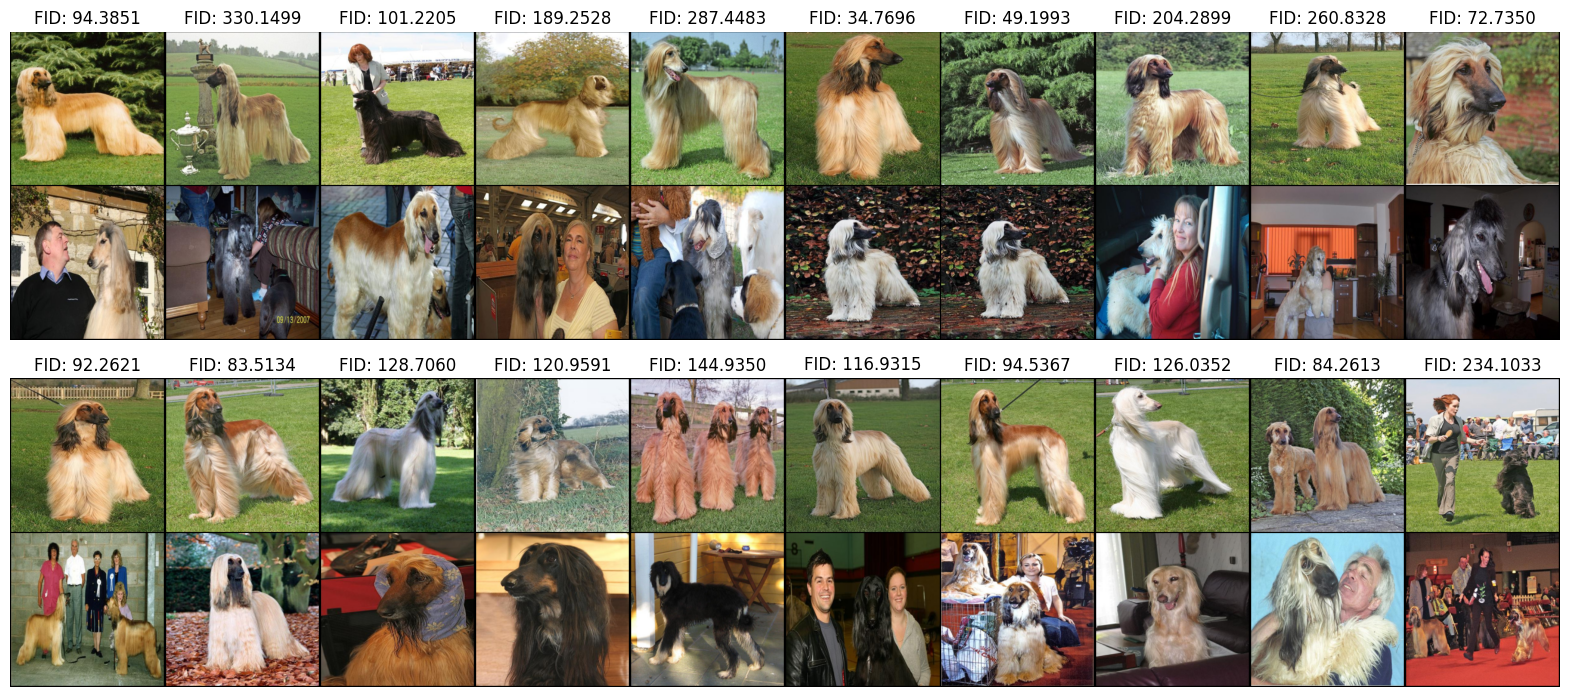

In [162]:
set1_dataloader = Data.DataLoader(set1, batch_size=1, pin_memory=True, num_workers=4)
set3_dataloader = Data.DataLoader(set3, batch_size=1, pin_memory=True, num_workers=4)

ncols = 10

set1_iter = iter(set1_dataloader)
set3_iter = iter(set3_dataloader)

fig, axes = plt.subplots(2, ncols, figsize=(20, 9))

fid_score_set1_3 = []

for ax in axes.ravel():
    ax.axis("off")
    ax.title.set_size(8)
    ax.title.set_fontweight('semibold')
    
for i in range(int(min(len(set1_dataloader), len(set3_dataloader)))):
    row = int(i / ncols)

    img1, _ = next(set1_iter)
    img2, _ = next(set3_iter)

    img1 = img1.cuda(dev)
    img2 = img2.cuda(dev)
    grid_tensor = torch.cat((img1, img2))
    
    fid_score = calculate_fretchet(img1, img2, inception_model)
    fid_score_set1_3.append(fid_score)
    grid = make_grid(grid_tensor, nrow=1)
    axes[row, i % ncols].set_title(f'FID: {fid_score:.4f}')
    axes[row, i % ncols].imshow(transfor_to_img(grid))

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


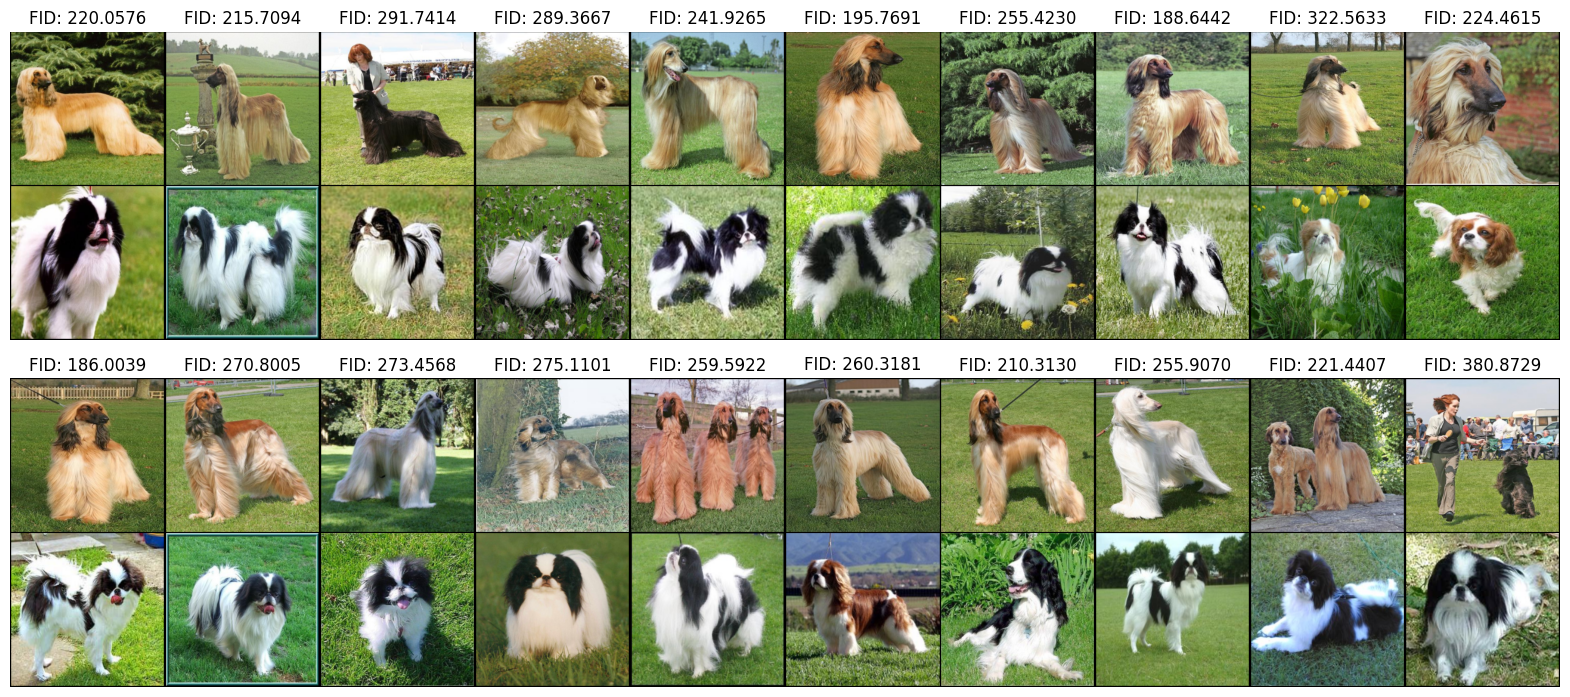

In [163]:
set1_dataloader = Data.DataLoader(set1, batch_size=1, pin_memory=True, num_workers=4)
set2_dataloader = Data.DataLoader(set2, batch_size=1, pin_memory=True, num_workers=4)

ncols = 10

set1_iter = iter(set1_dataloader)
set2_iter = iter(set2_dataloader)

fig, axes = plt.subplots(2, ncols, figsize=(20, 9))

for ax in axes.ravel():
    ax.axis("off")
    ax.title.set_size(8)
    ax.title.set_fontweight('semibold')
    
for i in range(int(min(len(set1_dataloader), len(set2_dataloader)))):
    row = int(i / ncols)

    img1, _ = next(set1_iter)
    img2, _ = next(set2_iter)

    img1 = img1.cuda(dev)
    img2 = img2.cuda(dev)
    grid_tensor = torch.cat((img1, img2))
    
    fid_score = calculate_fretchet(img1, img2, inception_model)
    fid_score_set1_3.append(fid_score)
    grid = make_grid(grid_tensor, nrow=1)
    axes[row, i % ncols].set_title(f'FID: {fid_score:.4f}')
    axes[row, i % ncols].imshow(transfor_to_img(grid))

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
